<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/Exercise_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

**RIM'S MEMO**


They ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload # reload automatically.
%autoreload 2 # reload automatically.
%matplotlib inline # display any charts or images. 

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

**RIM'S MEMO**

We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import * # import fastai V1 library
from fastai.metrics import error_rate # import fastai V1 library

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64 # 한 Step이 일어날 때 Parallel하게 처리되는 Data의 수.
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
help(untar_data) 
# 도움말을 보여준다. 
# untar_data는 URL을 인수로 전달해서 data를 download하고 extract하는 함수임. 

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



**RIM'S MEMO**

**URLs** is a class from fastai. datasets, we imported it as from fastai import 

**PETS** is a string constant with the path as ‘https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet


---

**PoxisPath** : non-Windows 파일 시스템 상에서 I/O를 포함한 File System Path 관련 동작 수행. 

In [0]:
path = untar_data(URLs.PETS); path # url을 통해 tgz(File Extension) 파일을 다운로드한 뒤, path에 저장한다. 
# URLs.PETS를 인수로 전달해서 data를 download하는 것을 볼 수 있음. 
# /root/.fastai/data/oxford-iiit-pet 경로에 다운로드가 된 것임. 

PosixPath('/root/.fastai/data/oxford-iiit-pet')

**RIM'S MEMO**

When you do have a path object, seeing what's in it actually takes a lot more typing than i would like. So sometimes we add functionality into existing Python stuff. One of the things we do is add a **ls()** method to path.

These are what's inside this path, so that's what we just downloaded.

In [0]:
path.ls()  # ls()을 통해, path에 저장되어있는 모든 변수들을 출력한다. 
# oxford-iiit-pet folder에는 annotations(주석이란 뜻)와 images라는 folder가 생성되었음. 

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

**RIM'S MEMO**

This is a really convenient function that's part of Python 3. it's fuctionality from **pathlib.** Path object is much better to use than strings. They let you use basically create sub paths like this. path_img is the path to the images in that dataset.  

In [0]:
path_anno = path/'annotations' # 'annotations'의 sub path를 생성한다. 
path_img = path/'images' # 'images'의 sub path를 생성한다. 
# 각 folder의 경로를 따로 지정하여 접근을 용이하게 함. 

In [0]:
print(path_anno) # path_anno를 출력한다. 

/root/.fastai/data/oxford-iiit-pet/annotations


The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

**RIM'S MEMO**

**get_image_files** will just grab an array of all of the image files based on extension in a path.

In [0]:
fnames = get_image_files(path_img) # path_img를 통해 get_image_files()를 사용, file names를 fnames에 저장한다.   
fnames[:5] # 5 fnames를 출력한다. 
# path_img 경로, 즉 path/'images'에 있는 file들을 get_image_files를 통해 extract한다. 이를 fnames에 저장. 

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_99.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_74.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_141.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_33.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_148.jpg')]

**RIM'S MEMO**

Regular expressions are a way to search a string in the text using pattern matching methods.

**r** : The string should be a raw string. Otherwise, \d would have to be written as \d so that Python doesn’t interpret it to be a special character.

**/** : first '/' in regex says, end of search.

**([^/]+)** : searches all characters except '/'.

**\d** : numerical digits, '+' sign denotes can be one or more of them.

**$** : end of search.


---


정규식은 /로 시작하는 것 같다. 

"^" : 이 패턴으로 시작해야한다. 

"[]" : 문자의 집합을 나타낸다.

"[^/]+" : /로 시작하는 하나 이상의 문자의 집합.  

"\d" : 숫자 0~9.

"+" : 앞 패턴이 하나 이상이어야함. 즉 \d+ 이므로 숫자가 하나 이상이어야한다. 

"$" : 이 패턴으로 종료되어야한다. 

/로 시작하는 문자의 집합에 _가 추가가 되었고, 숫자 0~9를 하나 이상 가져야한다.

**따라서 pat은 "/scottish_terrier_180.jpg"를 정규식을 통해 가져오는 것임.**

In [0]:
np.random.seed(2) # seed를 2로 지정한 뒤 난수를 발생시킨다. 
pat = r'/([^/]+)_\d+.jpg$' # String을 찾기 위해 정규식(a regular expression)을 이용한다. "'/을 제와한 모든 문자'+'_숫자'+'.jpg'"를 의미한다. 

**RIM'S MEMO**

**There is a class called ImageDataBunch from fastai.vision.data, which will hold all the data you need an i.e train, val sets.**

An **ImageDataBunch** represents all of the data you need to build a model and there's some factory method which try to make it really easy for you to create that data bunch - a training set, a validation set  with images and labels.

We need to extract the labels from the names. We are going to use **from_name_re**. re is the module in Python that does regular expression - things that's really useful for extracting text.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats) 
# 정규식을 통해 from_name_re()를 이용, ImageDataBunch를 생성한 뒤 data에 저장한다.

# from_name_re(path:PathOrStr, fnames:FilePathList, pat:str, valid_pct:float=0.2, **kwargs)
# pat regular expression을 통해 fnames list를 생성한다.
# **kwargs : keyword arguments, 
# imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 각 RGB 채널들의 means, standard deviations를 보여준다. 이를 통해 각 이미지 픽셀에 대해 정규화를 하는 것임. 

In [0]:
doc(ImageDataBunch) # Document의 도움말을 보여준다. 

# args vs. kwarg
가변 갯수의 인자들을 함수에 넣어준다. 가변 갯수의 인자라 함은, 사용자들이 얼마나 많은 인자들을 함수에 넣을지 모르는, 즉 갯수가 변할 수 있는 상황에서 args와 kwargs를 사용할 수 있다. 


> **args**


키워드 되지 않은 가변 갯수의 인자들을 함수에 보낼 때 사용한다. 


> **kwargs**


키워드된 가변 갯수의 인자들을 함수에 보낼 때 사용한다. **kwargs는 함수가 이름이 지정된 인자를 처리할 때 사용해야 한다. 


In [0]:
# *args 예시. 

def test_var_args(f_arg, *args):
    print ("내 이름 : ", f_arg)
    
    for arg in args:
        print ("내 다른 이름 : ", arg)

test_var_args("유림", "리무", "파티마")

In [0]:
# **kwargs 예시.

profile_dict_many= {
    "name" : "유림",
    "age" : 27,
    "height" : 162,
    "country" : "대한민국"
}

def myprofile_kwargs(**kwargs):
    for key,value in kwargs.items():
        print("{key} = {value}".format(key=key,value=value))
        
myprofile_kwargs(**profile_dict_many)

**RIM'S MEMO**

You can be see **data.show_batch** can be used to show me some of the contents in my data bunch. 

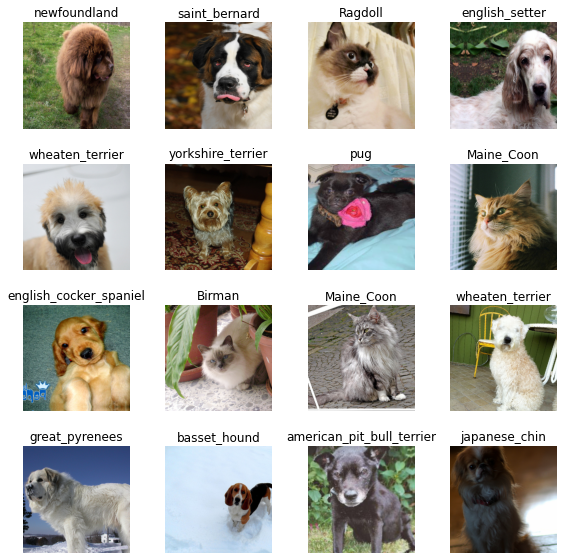

In [0]:
data.show_batch(rows=4, figsize=(8, 8)) # 저장된 data를 보여준다. rows는 display되는 rows와 columns의 갯수를 나타낸다. 

**RIM'S MEMO**

The other thing we want to do is to look at the labels. All of the possible label names are called your classes. With DataBunch, you can print out your **data.classes.**

We learnt earlier on at the top that there are 37 possible categories, so just checking len(data.classes), it is indeed 37. DataBunch will always have a property called **c.** **data.c** is a really important piece of information that is something like, or at least for classification problems it is, the number of classes. 

In [0]:
print(data.classes) # data.classes를 통해 data의 label names를 print한다. 
len(data.classes),data.c # category 갯수를 확인한다. 

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

**RIM'S MEMO**

It is to create a learner for a convolutuinal neural network, you just have to tell it two things: data and arch. There are lots of different ways of constructing a convolutional neural network.

The most important thing for you to know is that there's a particular kind of model called ResNet(Residual Network) which works extremely well nearly all the time.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate) # ResNet34 Model을 이용, a convolutional neural network를 위한 learner을 생성한 뒤 learn에 저장한다.  

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.model # learn이 어떤 model인지 보여준다. 

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

**RIM'S MEMO**

The first time I run this on a newly installed box, it downloads the ResNet34 pre-trained weights. What that means is that this particular model has actually been trained for a particular task. 

We will take a pre-trained model, and then we fit it so that instead of predicting a thousand categories of ImageNet with ImageNet data, it predicts the 37 categories of pets using your pet data. 

We have a ConvLearner, we can fit it. You can just use a method called **fit** but in practice, you should nearly always use a method called **fit_one_cycle.**

In [0]:
learn.fit_one_cycle(4) # fit_one_cycle()을 통해 4 epochs 만큼 학습한다. 

epoch,train_loss,valid_loss,error_rate,time
0,1.401556,0.348015,0.115697,01:14
1,0.620230,0.274906,0.087280,01:13
2,0.372345,0.234231,0.076455,01:14
3,0.261984,0.227977,0.072395,01:14


**RIM'S MEMO**

You can just go **learn.save** and give it a name. It's going to put it in a model subdirectory in the same place the data came from, so if you save different models or different data bunches from different datasets, they'll all be kept separate.

In [0]:
learn.save('stage-1') # Training한 것을 'stage-1'이라는 이름으로 저장한다. 

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

**RIM'S MEMO**

**ClassificationInterpretation** has methods for creating confusion matrix as well as plotting misclassified images. Learn object knows 2 things, data and model. The Model here is not just the architecture but a trained model with weights. 

In [0]:
interp = ClassificationInterpretation.from_learner(learn) # a confusion matrix와 incorrect images의 visualization을 보기 위해 ClassificationInterpretation를 생성한 뒤, interp에 저장한다. 

losses,idxs = interp.top_losses() # top_losses()를 통해 예측값과 실제값, loss와 probability를 확인한다. 

len(data.valid_ds)==len(losses)==len(idxs) # valid_ds is the default name of the validation set. valid_ds와 losses, idxs의 갯수가 동일한지 확인한다. 

True

**RIM'S MEMO**

One of the things, perhaps the most useful things to do is called **plot_top_losses.** a loss function is something that tells you how good was your prediction. 

By plotting the top losses, we are going to find out what were the things that we were the most wrong on, or the most confident about what we got wrong. 

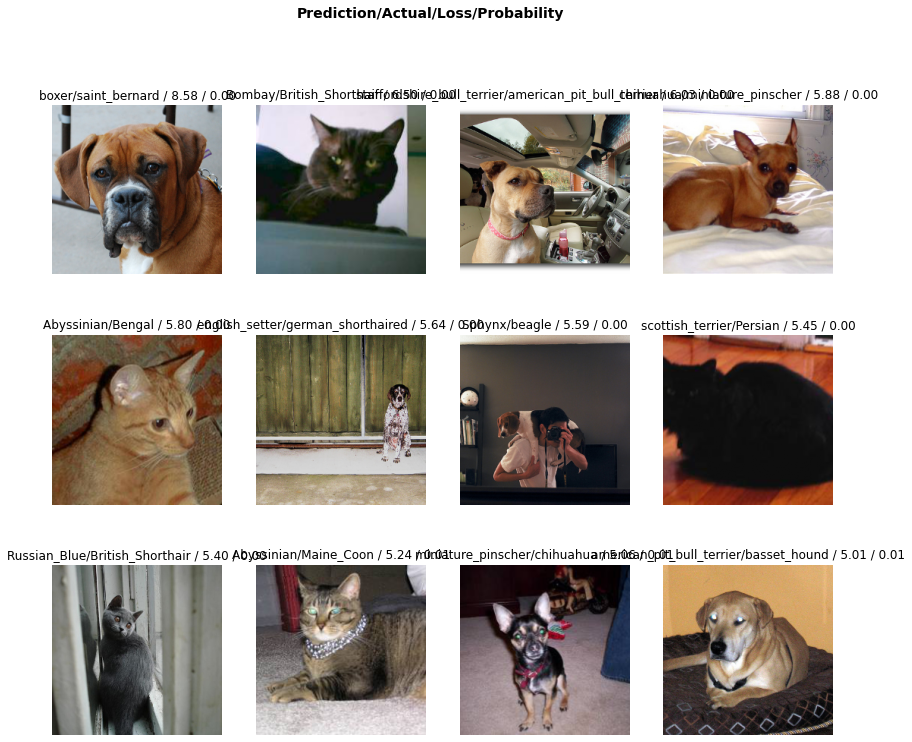

In [0]:
interp.plot_top_losses(12, figsize=(14,12)) # 가장 큰 loss를 갖는 samples의 images와 함께 예측값과 실제값, loss와 probability를 보여준다. 
# prediction, actual, loss, probability 값과 함께 이미지를 보여주는 함수임. 

**RIM'S MEMO**

To open up class documentation and source use **doc** function. doc will open up the documentation page for you. 

That's how we can look at top losses and these are perhaps the most important image classification interpretation tools that we have. 

In [0]:
doc(interp.plot_top_losses) # Document의 도움말을 보여준다.

**RIM'S MEMO**

Another useful tool, kind of, is to use something called **a confusion matrix** which basically shows you for every actual type of dog or cat, how many times was it predicted to be that dog or cat. 

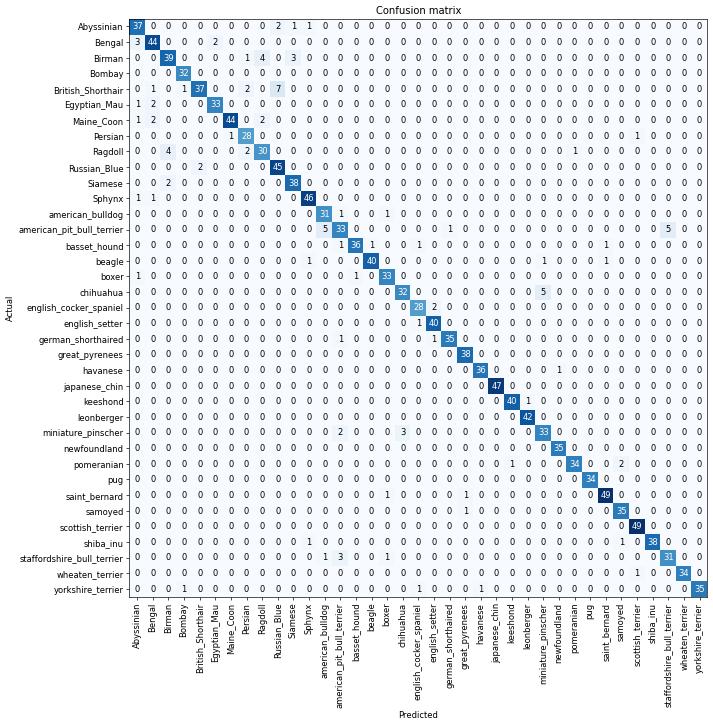

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # a confusion matrix를 생성해서, 어떤 dog와 cat가 그 dog와 cat로(ex. Abyssinian→Abyssinian) 몇 번 예측되었는지 보여준다. 
# dpi에 따라 confusion matrix의 사이즈가 달라지는 것을 확인하였음.

**RIM'S MEMO**

**most_confused** will simply grab out of the confusion matrix the particular combinations of predicted and actual that got wrong the most often. 

In [0]:
interp.most_confused(min_val=2) # 가장 예측이 잘못된 data의 예측값과 실제값, 그 빈도수를 보여준다.  

[('British_Shorthair', 'Russian_Blue', 7),
 ('american_pit_bull_terrier', 'american_bulldog', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('Birman', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Birman', 'Siamese', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Abyssinian', 'Russian_Blue', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('British_Shorthair', 'Persian', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('pomeranian', 'samoyed', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

**RIM'S MEMO**

**unfreeze()** is the thing that says please train the whole model. 



> **Unfreeze**

fastai 라이브러리에서 기본으로 제공하는 모델은 모델을 구성하는 마지막 fully-connected layer(이전 레이어의 모든 노드가 다음 레이어의 모든 노드에 연결된 레이어, fully-connected layer로 구성된 네트워크는 1차원 배열로만 이루어져 있음.)를 제외한 레이어가 잠겨있음. 즉 모든 레이어들을 학습 데이터에 따라 변하게 만들고 싶으면 수동으로 잠금을 풀어주어야 함. 예를 들어 원하는 결과를 얻지 못했을 경우 주어진 fit_one_cycle이 fully-connected layer만을 학습하는 것을 벗어나도록 잠금을 풀어주어야 함. 

In [0]:
learn.unfreeze() # 학습을 통해 잠긴 layer를 풀어준다. 

**RIM'S MEMO**

Then I can call fit_one_cycle again. **The error got much worse.** 

In [0]:
learn.fit_one_cycle(1) # 1 epoch만큼 학습한다. 

epoch,train_loss,valid_loss,error_rate,time
0,0.697417,0.378783,0.119756,01:15


**RIM'S MEMO**

This brings back the model that we saved earlier. Let's load that back up and now our models back to where it was before we killed it. 

In [0]:
learn.load('stage-1'); # 'stage-1'에 저장되었던 model을 load한다. 

**RIM'S MEMO**

Let's run **learning rate finder.** 

In [0]:
learn.lr_find() # 학습률(Learning Rate)를 찾는다. 
# lr = 1e-07부터 10까지, 학습을 100번 반복하면서, loss가 발산하기 전까지 lr을 찾아 보여줌. 

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


**RIM'S MEMO**

This will plot the result of our learning rate finder and what this basically shows you is this key parameter called a learning rate. You can see, once the learning rate gets passed **1e-04**, my loss gets worse. 

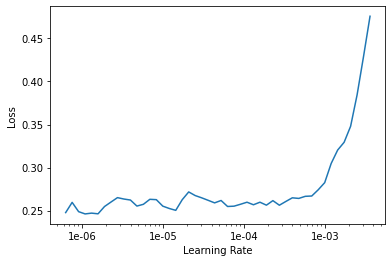

In [0]:
learn.recorder.plot() # Learning Rate와 Loss의 상관관계를 Graph로 나타낸다. Learning Rate가 1e-04를 지나면서 높은 Loss를 가진다.  
# 손실함수(Loss Function = Cost Function) : 그 신경망 성능이 얼마나 나쁜가.
# loss가 발산했을 때 lr 찾기를 멈추는 것을 볼 수 있음. 

**RIM'S MEMO**

**We can pass a range of learning rates to learn.fit_one_cycle.** 

In [0]:
learn.unfreeze() # 학습을 통해 잠긴 layer를 풀어준다. 
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4)) 
# Learning Rate의 구간을 정해(Loss가 낮은 구간) 2 epochs만큼 학습을 하였더니, error_Rate가 감소한 것을 볼 수 있다.  
# 가장 큰 lr이 1e-06과 1e-04 사이에 있도록 한다. 
# 1e-06, 1e-04 구간이 loss가 가장 낮음.  

epoch,train_loss,valid_loss,error_rate,time
0,0.231633,0.214781,0.075101,01:15
1,0.221978,0.210669,0.075778,01:15


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats) 
# 정규식을 통해 from_name_re()를 이용, ImageDataBunch를 생성한 뒤 data에 저장한다. 

In [0]:
bs/2 # 32.0
bs//2 # 32 
# /2를 하면 float으로 반환, //2를 하면 int로 반환함. 

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate) # ResNet50 Model을 이용, a convolutional neural network를 위한 learner을 생성한 뒤 learn에 저장한다.  

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


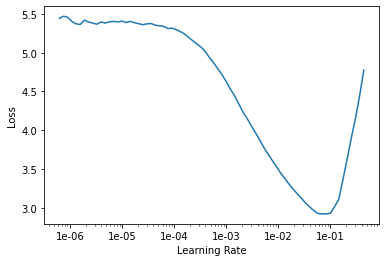

In [0]:
learn.lr_find() # 학습률(Learning Rate)를 찾는다.  
learn.recorder.plot() # Learning Rate와 Loss의 상관관계를 Graph로 나타낸다.

**lr_find()**는 lr = 1e-07부터 10까지, 학습을 100번 반복하면서, loss가 발산하기 전까지 lr을 찾아 보여줌. 각 learning rate에 대해 학습을 100번 실행했을 때 loss 값을 보여주는데, 직관적으로 learning rate가 작은 구간에서 loss가 높다면 그 구간의 learning rate는 쓸 필요가 없는 것임. 위 그래프의 경우 1e-03과 1e-02 사이에서 loss의 급감이 이루어지는데, 우리는 학습을 100번이나 시키지 않기 때문에, loss가 가장 작은 지점을 learning rate로 고르면 안됨. loss 값이 급감하는 지점, 기울기가 가장 가파르게 떨어지는 지점이 최적의 learning rate인 것임. 

**fit_one_cycle()**는 (1) lr 값을 직접 넣어주거나, (2) slice(lr)을 넣어주거나, (3) slice(어떤 lr 구간)을 넣어주거나, (4) 아무런 값도 넣지 않는 경우들이 있는데, (1)의 경우 loss-learning rate graph를 보고 직접 찾을 수 있고, (2) 전체 lr에서 가장 최적의 lr을 찾게 할 수 있고, (3) 어떤 lr 구간에서 가장 최적의 lr을 찾게 할 수 있고, (4) 아무런 값을 넣어주지 않으면 미리 셋팅된 0.003(3e-03)을 lr로 사용하게 되는 것임. 

위 그래프의 경우 1e-03에서 그래프의 급감이 이루어지고 있기 때문에 learn.fit_one_cycle(8) command처럼 lr 값을 별도로 찾지 않아도 된다. 

In [0]:
learn.fit_one_cycle(8) # 8 epochs만큼 학습한다. 

epoch,train_loss,valid_loss,error_rate,time
0,0.721140,0.284913,0.085927,01:49
1,0.508254,0.280539,0.086604,01:48
2,0.420888,0.275506,0.078484,01:48
3,0.352786,0.252144,0.075778,01:47
4,0.273526,0.207304,0.066982,01:47
5,0.175263,0.172860,0.054127,01:47
6,0.133166,0.158117,0.051421,01:48
7,0.103242,0.150017,0.051421,01:48


In [0]:
learn.save('stage-1-50') # 'stage-1-50'라고 저장한다. 

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze() # 학습을 통해 잠긴 layer를 풀어준다. 
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4)) # Learning Rate의 구간을 정해 3 epochs만큼 학습을 하였더니, error_Rate가 감소한 것을 볼 수 있다. 

epoch,train_loss,valid_loss,error_rate,time
0,0.118919,0.157715,0.055480,01:53
1,0.095406,0.153822,0.048714,01:53
2,0.099514,0.148076,0.048714,01:53


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50'); # 'stage-1-50'에 저장되었던 model을 load한다.

In [0]:
interp = ClassificationInterpretation.from_learner(learn) # ClassificationInterpretation를 생성한 뒤, interp에 저장한다.

In [0]:
interp.most_confused(min_val=2) # 가장 예측이 잘못된 sample의 예측값과 실제값, 그 빈도수를 보여준다. 

[('Bengal', 'Egyptian_Mau', 5),
 ('Birman', 'Ragdoll', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Ragdoll', 'Birman', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Bengal', 'Abyssinian', 3),
 ('British_Shorthair', 'Ragdoll', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_bulldog', 'saint_bernard', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('havanese', 'english_cocker_spaniel', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path # url을 통해 tgz(File Extension) 파일을 다운로드한 뒤, path에 저장한다. 

PosixPath('/root/.fastai/data/mnist_sample')

####Scenario 1: Labels are folder names

**RIM'S MEMO**

We can see there are a training set and the validation set already. 

In [0]:
path.ls() # ls()을 통해, path에 저장되어있는 모든 변수들을 출력한다.  

[PosixPath('/root/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_sample/valid'),
 PosixPath('/root/.fastai/data/mnist_sample/train')]

**RIM'S MEMO**

There are a folder called 3 and a folder called 7. Everything that's a three, we put that in a folder called 3. Everything that's a seven, we'll put in a folder called 7. 

In [0]:
(path/'train').ls() # ls()를 통해, 'train'에 저장되어있는 폴더명들(3, 7)을 출력한다. 

[PosixPath('/root/.fastai/data/mnist_sample/train/3'),
 PosixPath('/root/.fastai/data/mnist_sample/train/7')]

**RIM'S MEMO**

**Data Augmentation** : To get a set of transforms with default values that work pretty well in a wide range of tasks, it's often easiest to use **get_transforms.** Depending on the nature of the images in you data, you may want to adjust a few arguments, the most important being:

**do flip** : if True the image is randomly flipped (default behavior).

**flip_vert** : limit the flips to horizontal flips (when False) or to horizontal and vertical flips as well as 90-degrees rotations (when True).


---


There are a number of ways to create an ImageDataBunch. One common approach is to use **Imagenet-style folders** with **ImageDataBunch.from_folder.**

In [0]:
tfms = get_transforms(do_flip=False) # get_transfroms(do_flip=Fasle)를 통해, 데이터 특성에 따른 몇 가지 인수를 조정한다. do_flip을 False로 하여 사진이 뒤집히는 것을 막는다.(숫자 이미지이므로 이 작업이 불필요.)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26) # 숫자 이미지를 불러와서 data에 저장함. 사이즈는 26*26 pixels이다. 

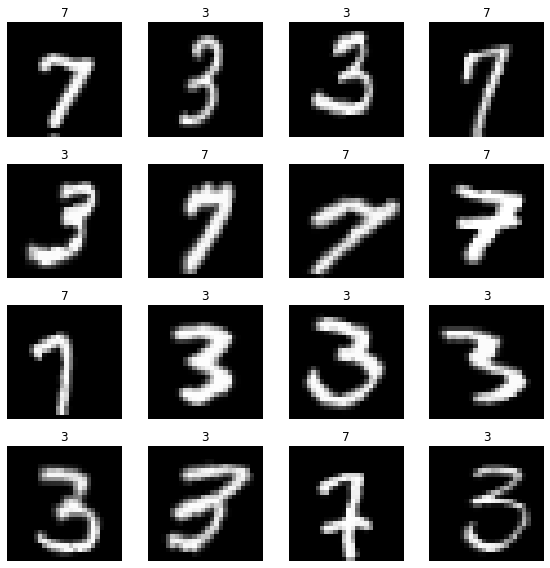

In [0]:
data.show_batch(rows=4, figsize=(8,8)) # 저장된 data를 보여준다. rows는 display되는 rows와 columns의 갯수를 나타낸다. 

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy) # cnn_learner()을 통해, a pretrained model을 자동으로 불러온다. 
learn.fit(2) # how many epochs to train for.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.188349,0.098839,0.971050,00:15
1,0.116290,0.054792,0.982336,00:15


####Scenario 2: CSV file

In [0]:
df = pd.read_csv(path/'labels.csv') # pandas에서 제공하는 read_csv() 함수를 통해 csv 파일을 불러온 뒤, df(dataframe)에 저장한다. 
df.head() # 저장된 df 중 최초 5개의 행을 보여준다. 

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


**RIM'S MEMO**

For each file name, what's its label. In this case, labels are not three or seven, they are 0 or 1 which is it a 7 or not. So that's another possibility. If this is how your labels are, you can use **from_csv.**

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28) # csv 파일을 통한 ImageDataBunch를 생성한 뒤, data에 저장한다.  

[0, 1]

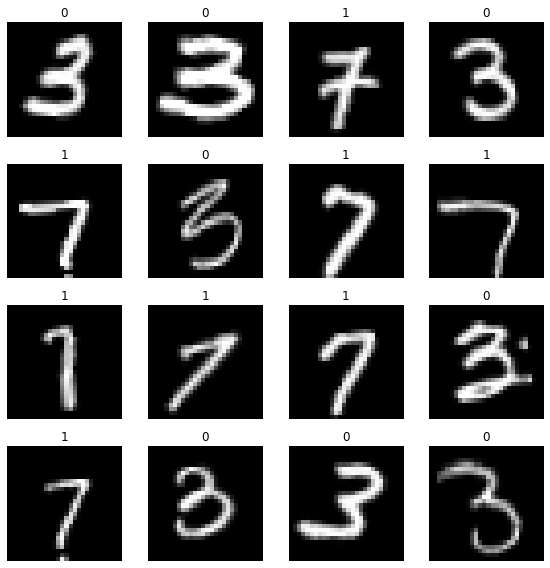

In [0]:
data.show_batch(rows=4, figsize=(8,8)) # 저장된 data를 출력한다.
data.classes # "7인지 아닌지"를 나타내기 위해, 7의 Label은 1, 3의 Label은 0이다. 따라서 classes는 0과 1로 구성된다. 

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24) # Dataframe을 통한 ImageDataBunch를 생성한 뒤, data에 저장한다. 
data.classes # classes를 보여준다. 

[0, 1]

####Scenario 3: Using regular expression 

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:6] # ImageDataBunch를 생성하기 전, 각 파일의 the exact path를 fn_paths에 저장한다. from_name_re()를 사용하기 위해서는 각 파일의 정확한 path가 필요하다. 

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/31559.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/46882.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/26209.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/41391.png')]

In [0]:
pat = r"/(\d)/\d+\.png$" # 정규식(a regular expression).
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24) # 정규식을 사용, file name으로부터 Label을 얻을 수 있다.  
data.classes # classes를 보여준다. 

['3', '7']

####Scenario 4: Something more complex

In [0]:
# def get_labels(file_path): return '3' if '/3/' in str(file_path) else '7'
# data = ImageDataBunch.from_name_func(path, fn_paths, label_func=get_labels, ds_tfms=tfms, size=24)

data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24, label_func = lambda x: '3' if '/3/' in str(x) else '7') 
# label_func을 이용해서 ImageDataBunch를 생성한다. 파일명(string)에 '/3/'이 있을 경우 label은 3, 그렇지 않으면 label은 7이다.   
data.classes # classes를 보여준다. 

['3', '7']

####Scenario 5: You need something even more flexible

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths] # fn_paths(string)에 '/3/'이 있을 경우 label은 3, 그렇지 않으면 label은 7이다.   
labels[:5] # 5 labels를 출력한다. 

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24) # lists를 통한 ImageDataBunch를 생성한 뒤, data에 저장한다. 
data.classes # classes를 보여준다. 

['3', '7']